# Independent Component Analysis

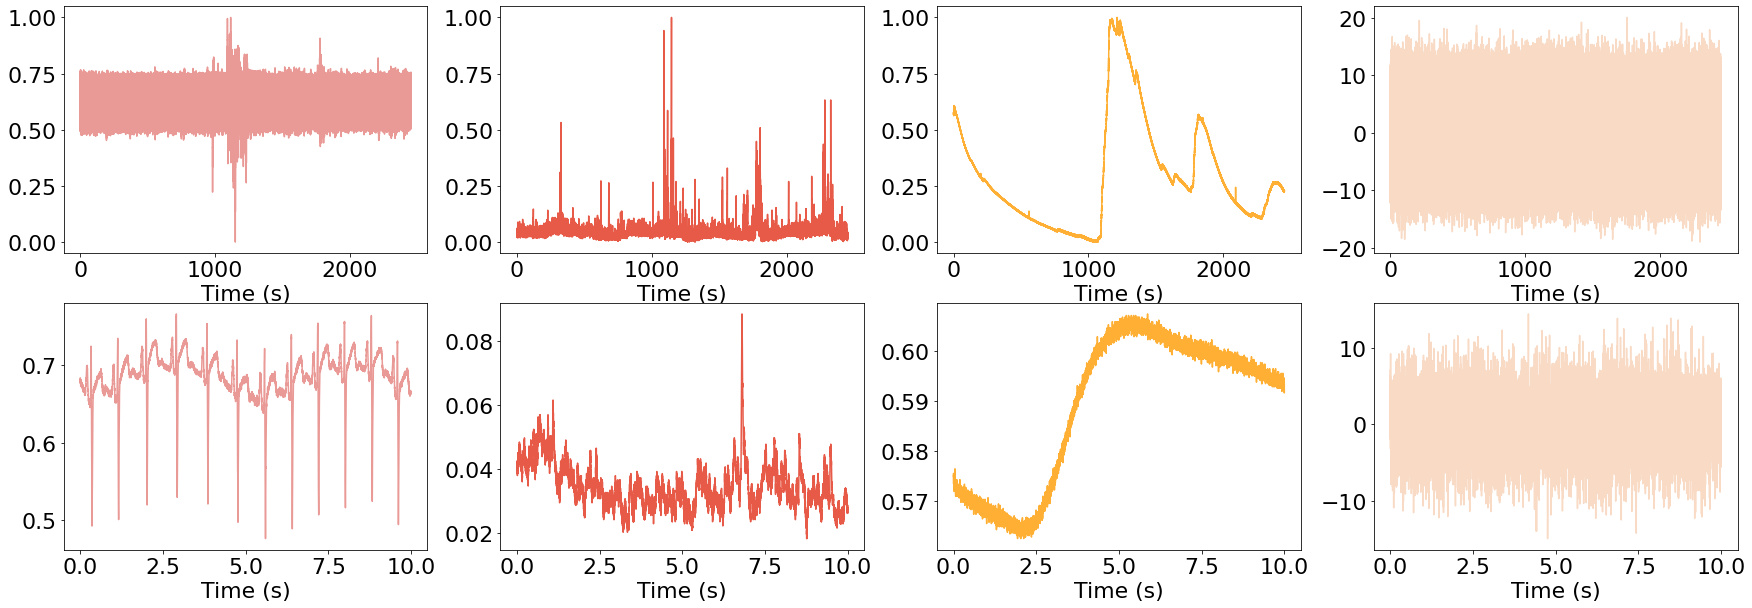

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_linnerud
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import os
import seaborn as sns

matplotlib.rcParams.update({'font.size': 22})

colors = ["#EA9A96", "#E75A48", "#FFB034", "#F8DAC5"]

path_to_data = "/home/fmachado/Downloads/CASE_full/data/interpolated/physiological"
subject = "1"
fs = 250

df_raw = pd.read_csv(os.path.join(path_to_data, f'sub_{subject}.csv'))
times = df_raw["daqtime"].values/1000

noise = np.random.normal(0, 1, df_raw.shape[0])*4

df_signals = pd.DataFrame(MinMaxScaler().fit_transform(df_raw[["ecg", "emg_zygo","gsr"]]), columns=["ecg", "emg_zygo","gsr"])
df_signals["noise"] = noise

f, ax = plt.subplots(2, df_signals.shape[1], figsize=(30, 10))
for i, component in enumerate(df_signals.values.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:10000], component[:10000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")

## Create a mixture of the signals

In [2]:
mixing_matrix = np.asarray([[0.002, 0.1, 0.01, 0.9], 
                            [0.005, 0.95, -0.1, 0.8], 
                            [0.001, 0.1, 0.001, 0.7], 
                            [0.05, 0.1, 0.2, 0.6]])

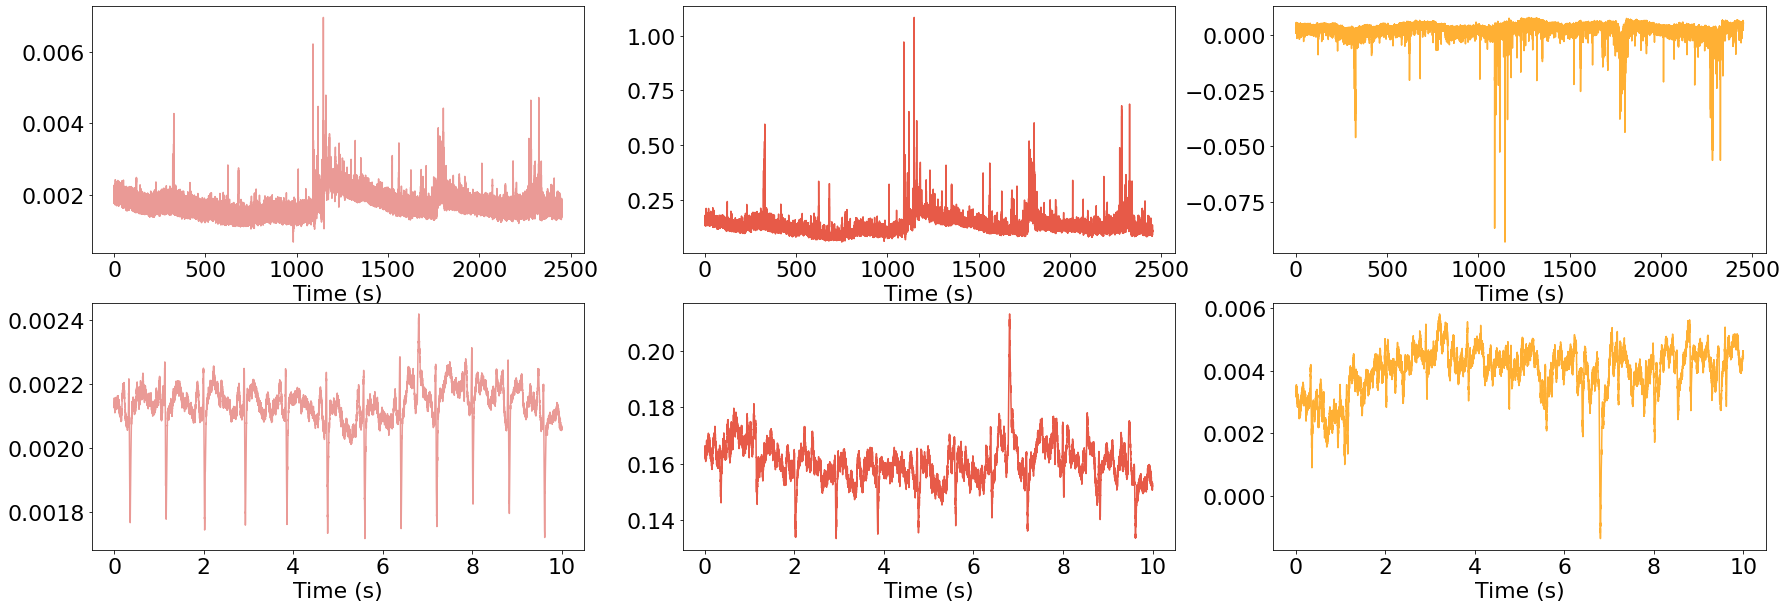

In [3]:
# Build the mixture without the noise component
data = np.matmul(df_signals.values[:, :-1], mixing_matrix[:-1, :-1])

f, ax = plt.subplots(2, data.shape[1], figsize=(30, 10))
for i, component in enumerate(data.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:10000], component[:10000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")

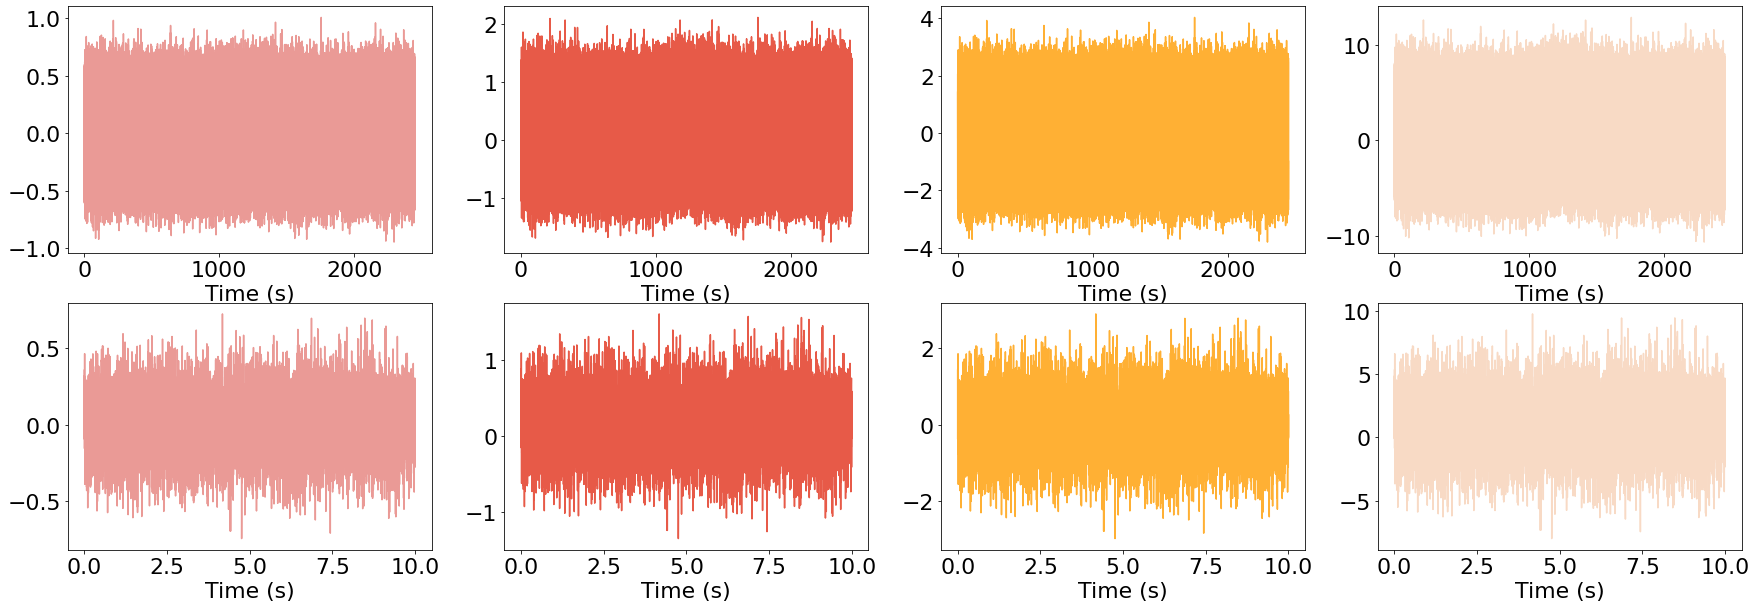

In [4]:
data = np.matmul(df_signals.values, mixing_matrix)

f, ax = plt.subplots(2, data.shape[1], figsize=(30, 10))
for i, component in enumerate(data.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:10000], component[:10000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")

## Apply FastICA to the mixture with noise

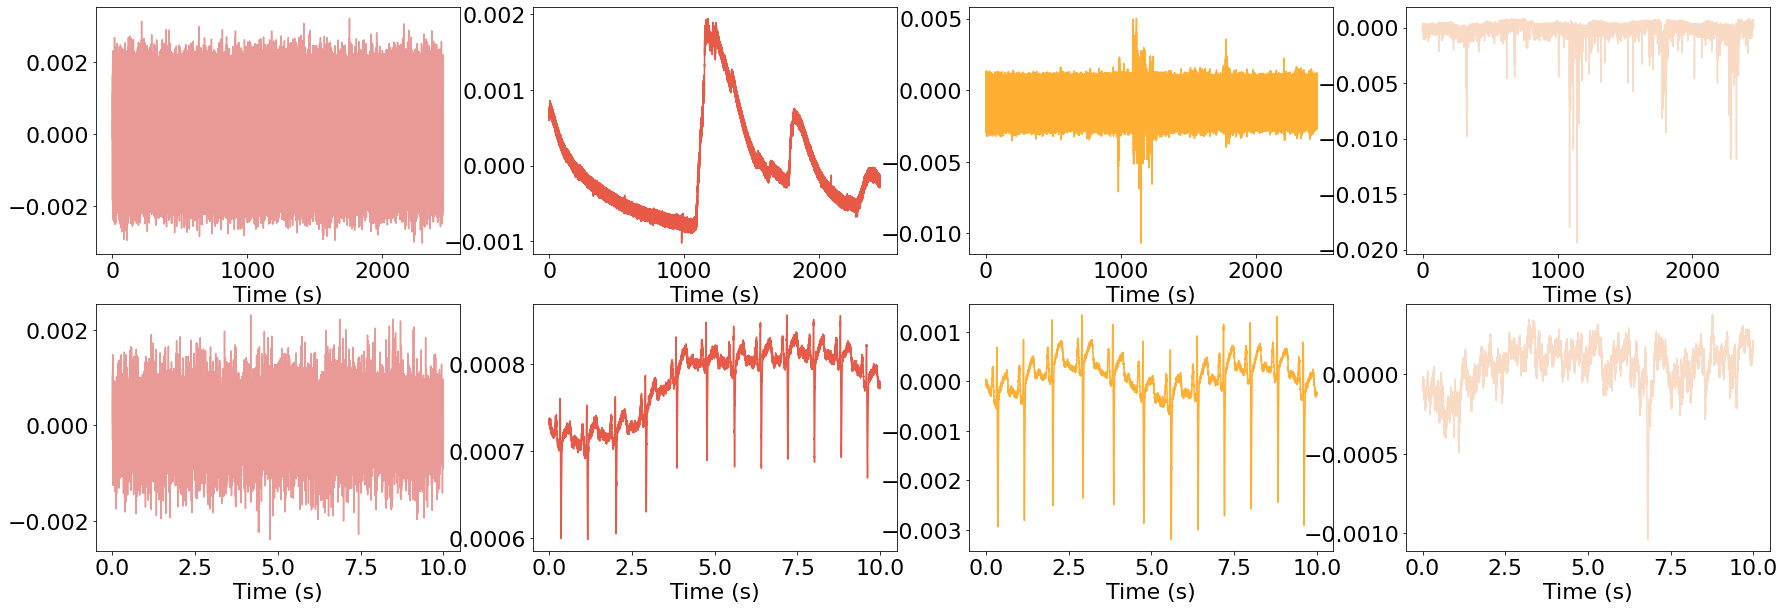

In [5]:
transformer = FastICA(n_components=data.shape[-1], random_state=0)
X_transformed = transformer.fit_transform(data)
X_transformed.shape

f, ax = plt.subplots(2, X_transformed.shape[1], figsize=(30, 10))
for i, component in enumerate(X_transformed.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:10000], component[:10000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")

## Reconstruct components

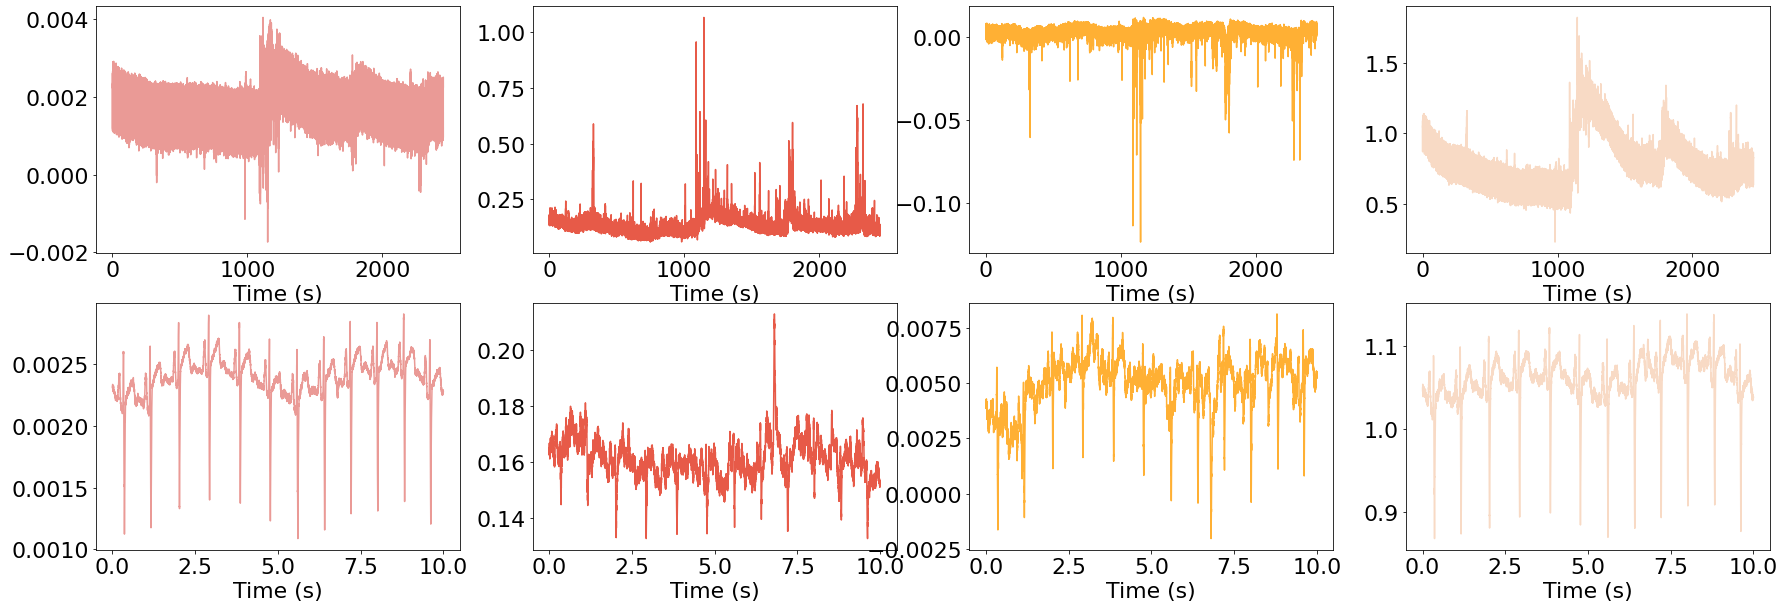

In [6]:
## Remove bad components
components_rejected = [0]

for i in components_rejected:
    X_transformed[:, i] = 0

## Reconstrctured Signals
X_restored = transformer.inverse_transform(X_transformed)

f, ax = plt.subplots(2, X_restored.shape[1], figsize=(30, 10))
for i, component in enumerate(X_restored.T):
    ax[0, i].plot(times, component, color=colors[i])
    ax[1, i].plot(times[:10000], component[:10000], color=colors[i])
    ax[0, i].set_xlabel("Time (s)")
    ax[1, i].set_xlabel("Time (s)")